# 1. SVC 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
X, y = make_moons(n_samples=200, random_state=42, shuffle=True)
train_amount = int(X.shape[0]/100*80)
X_train, y_train = X[:train_amount], y[:train_amount]
X_test, y_test = X[train_amount:], y[train_amount:]

## 1.1 SVC

In [3]:
def make_meshgrid(X, h=.01):
    """Create a mesh grid based on vectors X and Y."""
    if X.shape[1] > 2:
        raise ValueError('Requires a matrix of 2 features for visualization purposes.')
    
    x_min = X.min() - 1
    x_max = X.max() + 1
        
    x = np.arange(x_min, x_max, h)
        
    xx, yy = np.meshgrid(x, x)
    
    return xx, yy



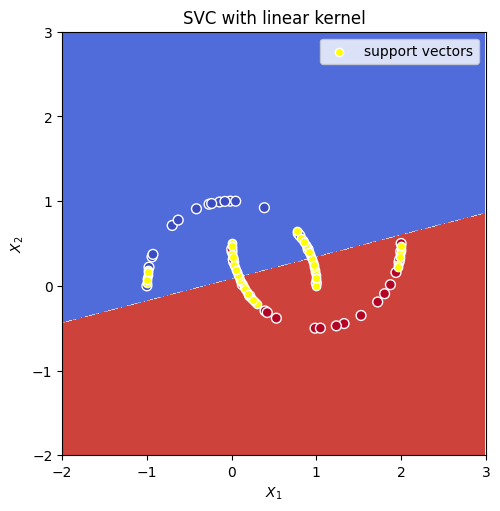

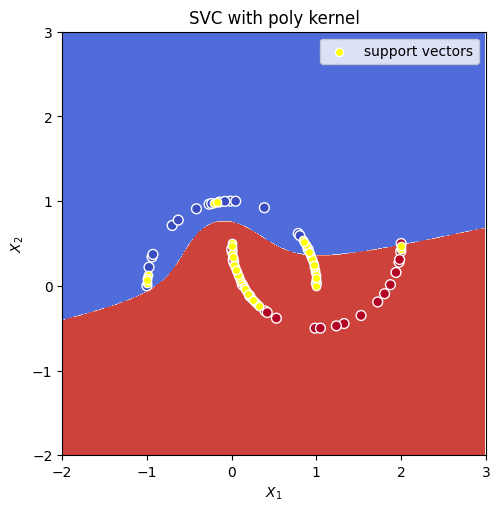

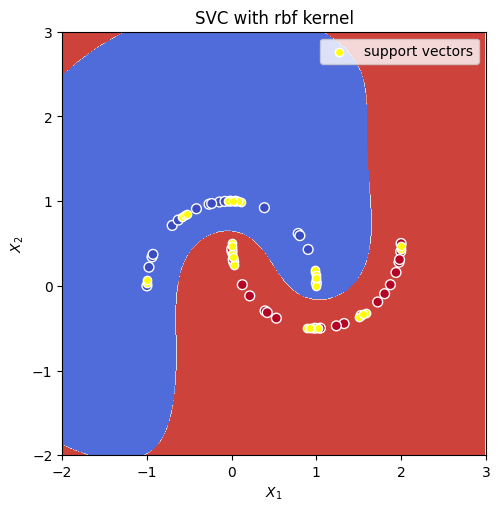

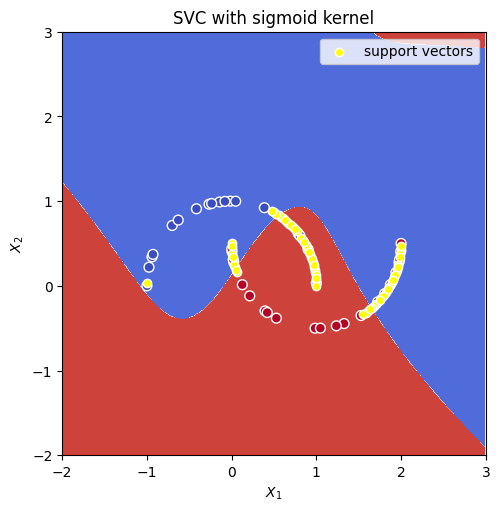

In [4]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels: 
    svc = SVC(kernel= kernel)
    svc.fit(X_train, y_train)

    xx, yy = make_meshgrid(X)
    grid = np.c_[xx.ravel(), yy.ravel()]

    svm_pred = svc.predict(grid).reshape(xx.shape)

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), layout="constrained")
    axes.contourf(xx, yy, svm_pred, cmap=plt.cm.coolwarm)
    axes.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor='white', linewidth=1, s=50, cmap=plt.cm.coolwarm)
    axes.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], edgecolor='white', color='yellow', label='support vectors')
    axes.set(aspect='equal',
               xlim=(X.min() - 1, X.max() + 1),
               ylim=(X.min() - 1, X.max() + 1),
               xlabel='$X_1$',
               ylabel='$X_2$')
    axes.set_title(f'SVC with {kernel} kernel')
    axes.legend()
    plt.show()

## Kernels

Linear as the name suggest tries to create the beste linear separation between the 2 classes with a linear line.

Poly predicts the polynomial kernel between X and Y dependend on the degree value.

When the RBF kernel is chosen two parameters must be considered: C and gamma. the parameter c trades off missclassification of training examples against simplicity of the decision surface. low C makes the decision surface smooth, while high C aims at classifying all training examples correctly. the gamma defines how much influence a signle training example has.

Sigmoid gives a strange seperation back likely due to the fact that there are negative values in this dataset.

# 2. Model Evaluation

In [5]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay

## 2.1 load the data/understand the dataset globally
looking at the data below we can see that it contains 2 types of breast cancer(malignant and benign). Each cancer is measured in 30 ways(e.g radius_mean, texture_mean). 

In [6]:
df = pd.read_csv('data/breast-cancer.csv')
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## Exploratory analysis
Because there are 2 groups and loads of parameters which we don't know what is the most important. We can use Linear Discriminant Analysis(LDA) to find the component that maximizes the separation of the two groups(malignant and benign).

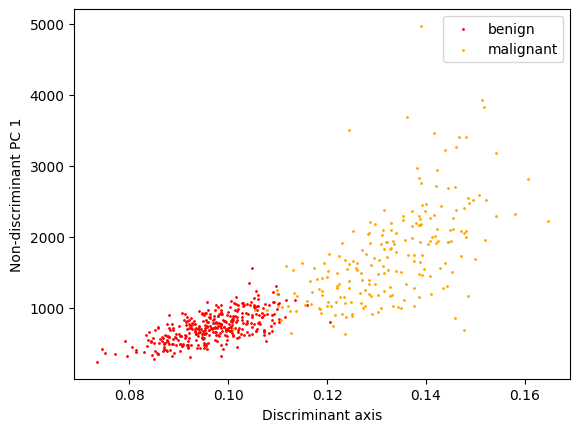

In [7]:
# devide the data
malignant = np.array(df[df['diagnosis'] == 'M'].values[:, 2:], dtype=float)
benign = np.array(df[df['diagnosis'] == 'B'].values[:, 2:], dtype=float)

#calculate the mean and the covariance
meanM = malignant.mean(axis=0)
meanB = benign.mean(axis=0)
nM = malignant.shape[0]
nB = benign.shape[0]
covM = np.cov(malignant.T)
covB = np.cov(benign.T)

#calculate the pooled covariance matrix
pooled = ((nB -1) * covB +(nM - 1) * covM) / (nB + nM -2)

#project the data onto the disciminant axis
a = np.linalg.inv(pooled) @ (meanM - meanB) 
a /= np.sqrt((a ** 2).sum())

tM = malignant @ a
tB = benign @ a

# deflate both groups, combine and plot data
Em = malignant - tM[:, None] * a[None, :]
Eb = benign - tB[:, None] * a[None, :]

X = np.concatenate((Em, Eb), axis=0)
S = np.cov(X.T)
vals, vecs = np.linalg.eig(S)
order = vals.argsort()[::-1]
vecs = vecs[:, order]
vals = vals[order]
Tm = malignant @ vecs
Tb = benign @ vecs

plt.scatter(tB, Tb[:, 0], s=1, c="red", label='benign')
plt.scatter(tM, Tm[:, 0], s=1, c="orange", label='malignant')
plt.xlabel("Discriminant axis")
plt.ylabel("Non-discriminant PC 1")
plt.legend()
plt.show()


In [8]:
print(order)
print(vals/sum(vals)*100)
print("The first feature radius_mean in this dataset has 98% of the separation between the two groups")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 26]
[ 9.82044672e+01  1.61764899e+00  1.55751074e-01  1.20931834e-02
  8.82724495e-03  6.64883907e-04  4.01713380e-04  8.22017111e-05
  3.44130323e-05  1.86016007e-05  6.98917414e-06  1.65905074e-06
  6.99641334e-07  4.77681274e-07  2.93470254e-07  1.40418344e-07
  8.23588250e-08  5.19694263e-08  4.08147829e-08  3.61896671e-08
  1.68894867e-08  1.23611064e-08  7.38689799e-09  6.27353255e-09
  3.56926361e-09  2.71026566e-09  6.63379946e-10  5.42491324e-10
  2.18755120e-10 -8.79002962e-21]
The first feature radius_mean in this dataset has 98% of the separation between the two groups


## Preprocess data

In [9]:
X = np.array(df.values[:, 2], dtype=float)
X = np.reshape(X, (X.shape[0], 1))

y = df.values[:, 1]
encoded_y = preprocessing.LabelEncoder()
y = np.array(encoded_y.fit(y).transform(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9001)

## Modeling

### SVC

In [10]:
svc = SVC(random_state=42)
params = {
    'kernel': ('poly', 'rbf', 'sigmoid'),
    'gamma': ('scale', 'auto'),
    'max_iter': (10, 20, 40),
}
grid_svc = GridSearchCV(svc, params, verbose=1)
best_svc = grid_svc.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=40).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=40).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=40).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=40).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=40).  Consider pre-processing

In [11]:
best_svc.get_params

<bound method BaseEstimator.get_params of GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'gamma': ('scale', 'auto'),
                         'kernel': ('poly', 'rbf', 'sigmoid'),
                         'max_iter': (10, 20, 40)},
             verbose=1)>

### Logistic regression

In [12]:
logistic_regression = LogisticRegression(random_state=42)
params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    
}
grid_logistic = GridSearchCV(logistic_regression, params, verbose=1)
best_logistic_regression = grid_logistic.fit(X_train,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

## Evaluation
a confussion matrix helps to see how well the models predict a certain class. In the confusion matrices below the 0 and 1 on both axis means benign and malignant. It predicts well when a sample is benign in 71 out of 72 cases. for the malignant the prediction went not so well it predicted 31 correct and 11 not correct. this could be because the dataset is not even between malignant and benign.

A precision recall curve is a great way to visualize how the model predict the positive class. It was mentioned in the assignment that the number of false negatives are more important so looking at the positive value which is malignant is not a great option to visualize how well the model works.

### SVC

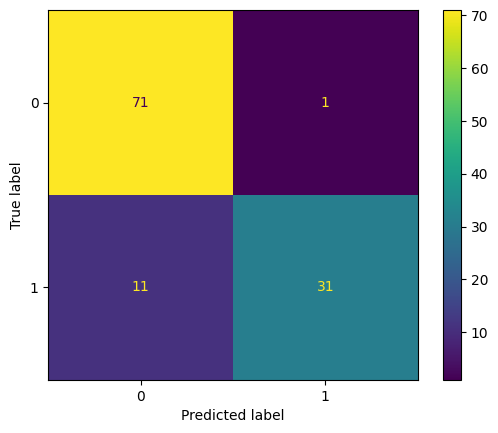

In [13]:
ConfusionMatrixDisplay.from_estimator(best_svc, X_test, y_test)

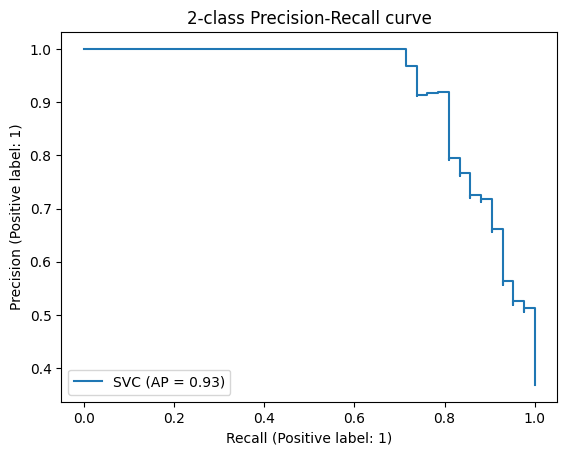

In [14]:
display = PrecisionRecallDisplay.from_estimator(
    best_svc, X_test, y_test, name="SVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

### Logistic Regression

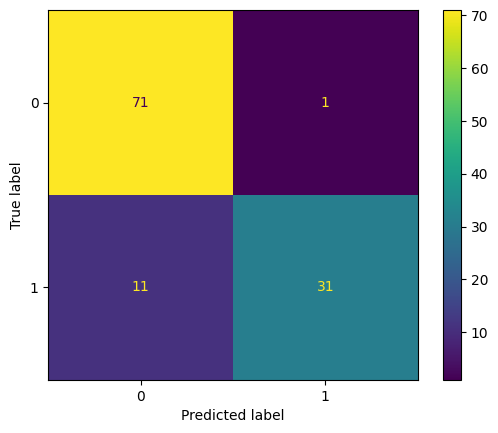

In [15]:
ConfusionMatrixDisplay.from_estimator(best_logistic_regression, X_test, y_test)

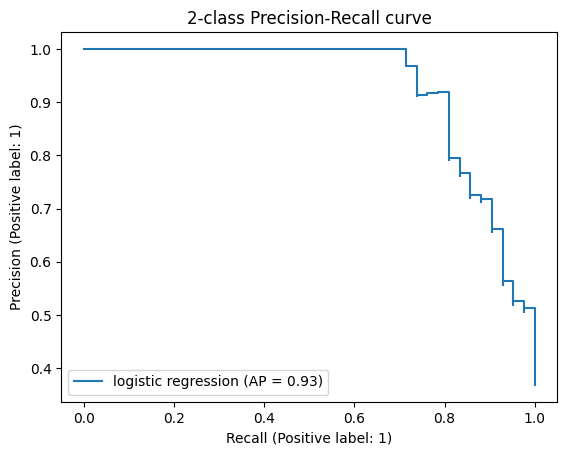

In [16]:
display = PrecisionRecallDisplay.from_estimator(
    best_logistic_regression, X_test, y_test, name="logistic regression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")